In [1]:
!pip install pandas numpy glob os matplotlib seaborn networkx

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
# Define the path and get all CSV files
path = "../datas/Data Coaching Fitbit/"
files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
# List to store data from all CSVs
dfs = []

# Read all CSV files
for file in files:
    df = pd.read_csv(file)
    
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Keep only weekdays (Monday to Friday)
    df = df[df['date'].dt.weekday < 5]
    
    # Keep only records before 18:00
    df = df[df['date'].dt.hour < 18]

    # Append the cleaned data
    dfs.append(df)

In [5]:
# Concatenate all data
df = pd.concat(dfs, ignore_index=True)

In [6]:
# Compute individual means for steps
individual_means = df.groupby(['treatment_id', df['date'].dt.date])['steps'].mean().reset_index()

In [7]:
# Convert 'date' back to datetime format
individual_means['date'] = pd.to_datetime(individual_means['date'])

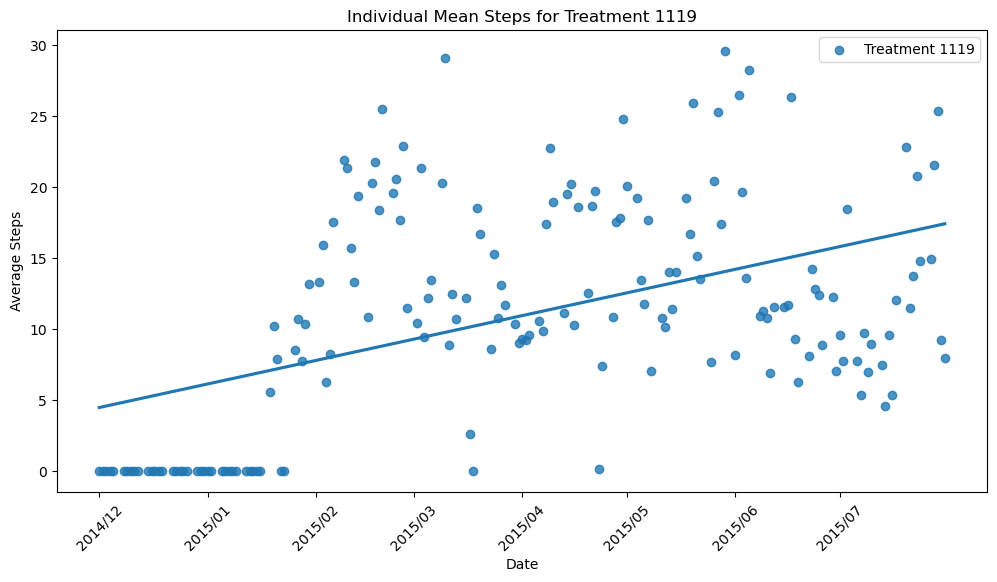

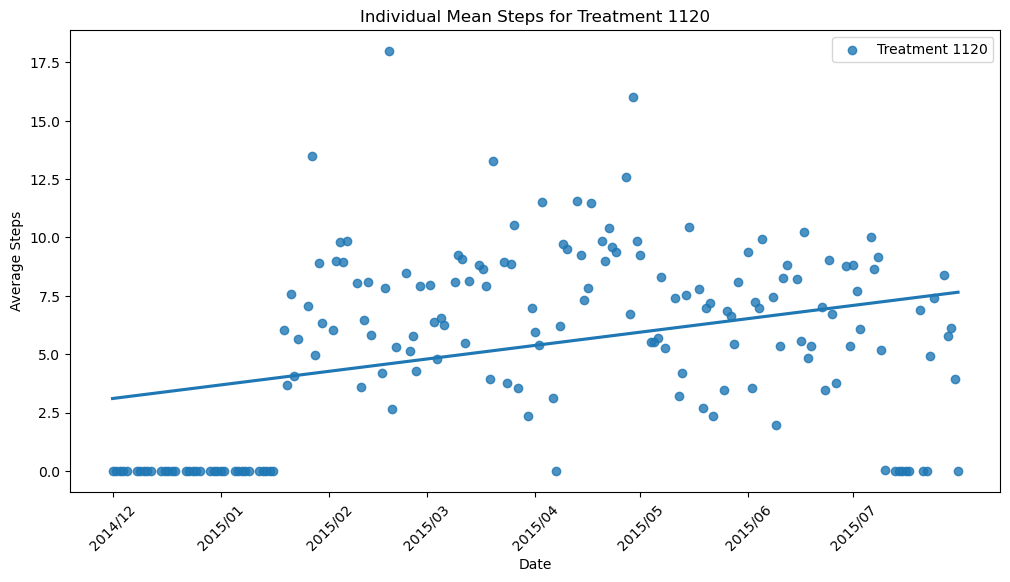

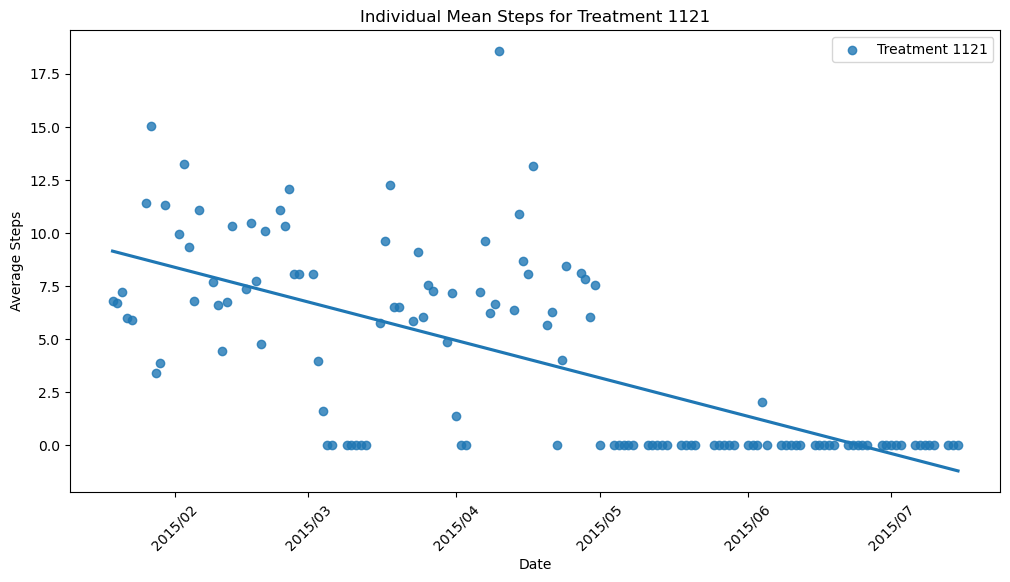

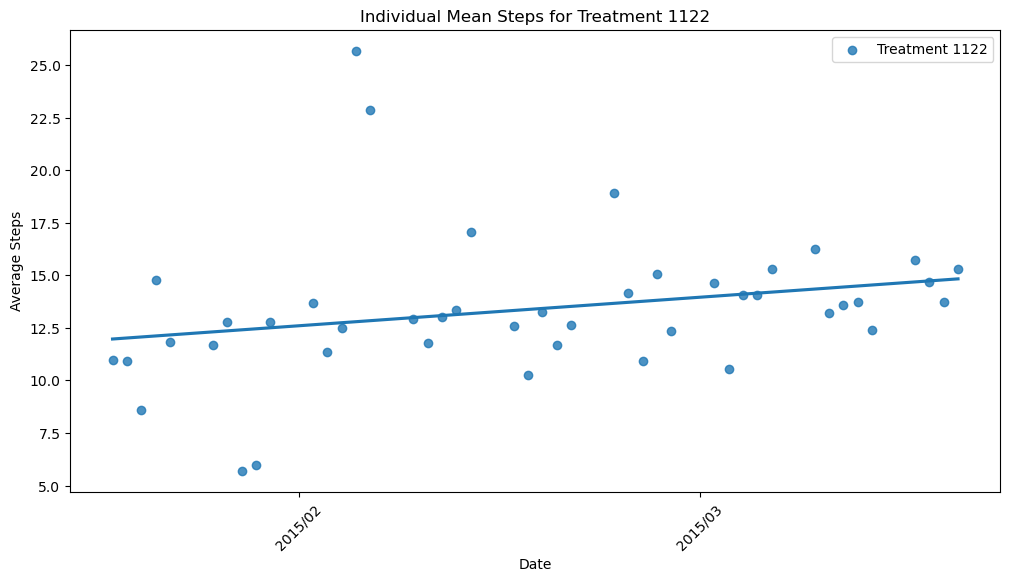

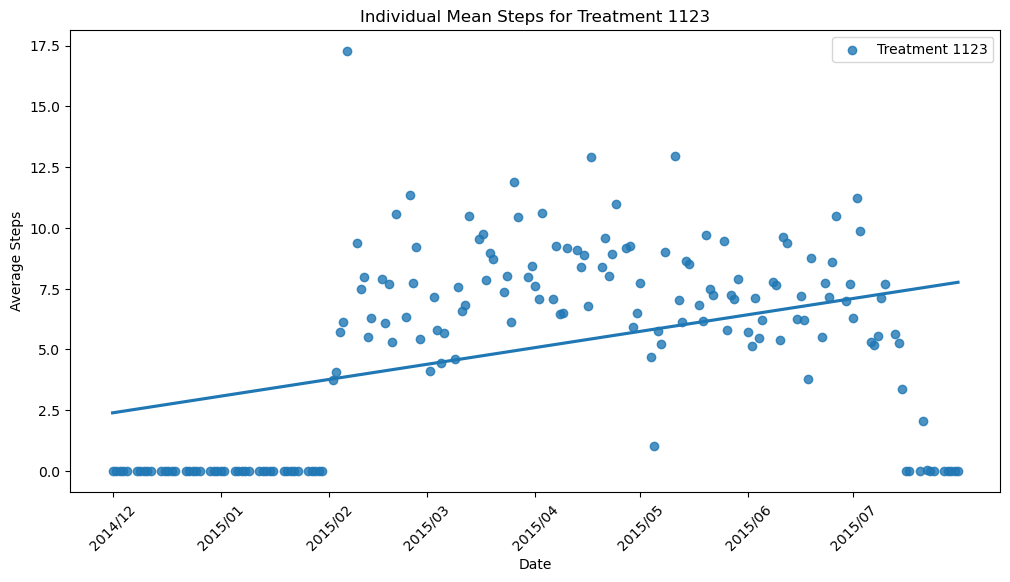

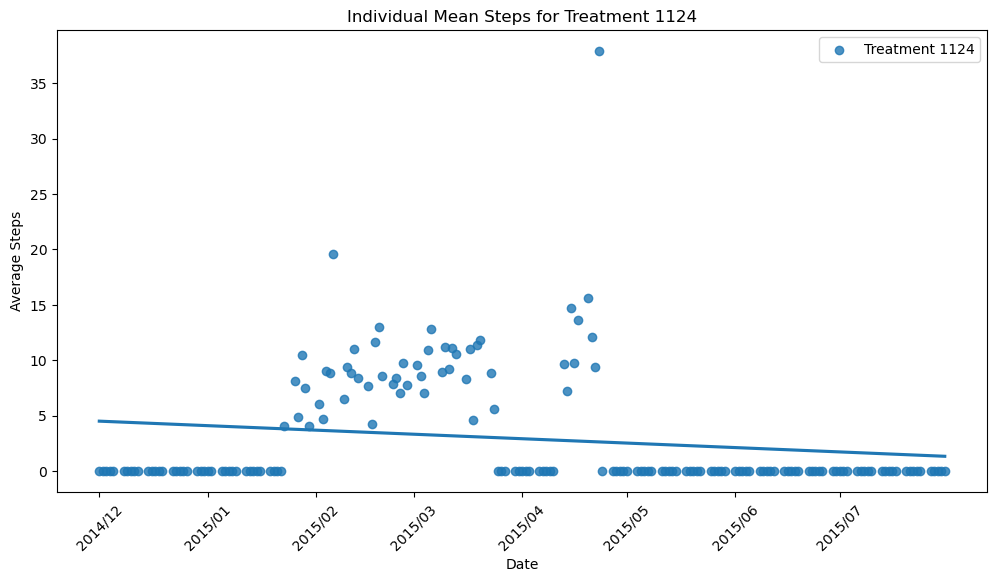

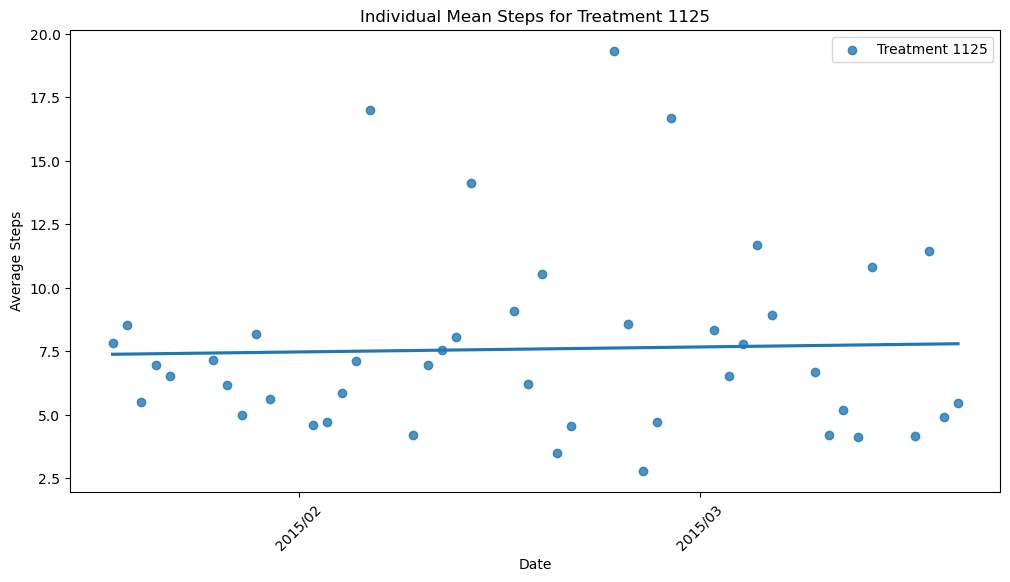

In [8]:
# -------- PLOT 1: Individual plots per `treatment_id` --------
treatment_ids = individual_means['treatment_id'].unique()

for treatment in treatment_ids:
    plt.figure(figsize=(12, 6))
    
    # Filter data for the current treatment_id
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()  # Use .copy() here
    
    # Convert 'date' to numeric for regression (safe modification)
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days
    
    # Plot regression for this individual
    sns.regplot(data=subset, x='date_numeric', y='steps', scatter=True, ci=None, label=f'Treatment {treatment}')
    
    # Set the x-ticks to the first day of each month (same as Plot 2)
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')  # First day of each month
    month_numeric = (months - subset['date'].min()).days  # Convert the months to numeric
    
    # Apply the same x-tick formatting as in Plot 2 (YYYY/MM format)
    plt.xticks(month_numeric, months.strftime('%Y/%m'), rotation=45)  # Format x-ticks as YYYY/MM and rotate for better readability
    
    # Formatting
    plt.title(f"Individual Mean Steps for Treatment {treatment}")
    plt.xlabel("Date")
    plt.ylabel("Average Steps")
    plt.legend()
    plt.show()

Average number of steps: 5.67 by minute
Average number of steps: 340.37 by hour
Average number of steps: 8168.95 by day


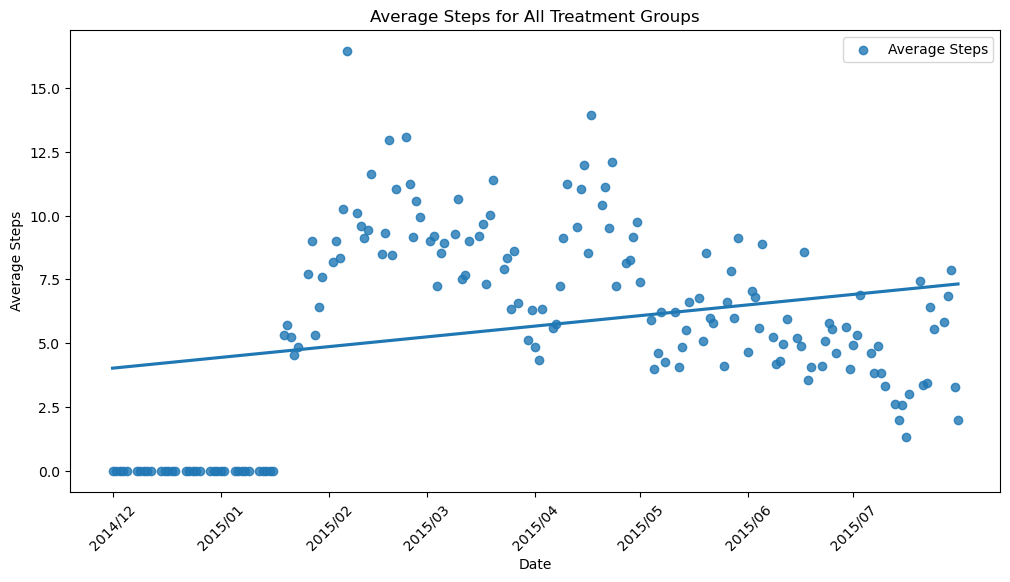

In [9]:
# -------- PLOT 2: Average steps for all treatment_ids --------

# Compute the average of all individuals' steps per day
average_steps = df.groupby([df['date'].dt.date])['steps'].mean().reset_index()

# Convert 'date' back to datetime format
average_steps['date'] = pd.to_datetime(average_steps['date'])

# Calculate and print the average number of steps
overall_avg_steps = average_steps['steps'].mean()
print(f"Average number of steps: {overall_avg_steps:.2f} by minute")
print(f"Average number of steps: {overall_avg_steps * 60:.2f} by hour")
print(f"Average number of steps: {overall_avg_steps * 60 * 24:.2f} by day")

# Plot the average steps for all treatment_ids
plt.figure(figsize=(12, 6))

# Convert 'date' to numeric for regression (safe modification)
average_steps['date_numeric'] = (average_steps['date'] - average_steps['date'].min()).dt.days

# Plot the regression for the average steps
sns.regplot(data=average_steps, x='date_numeric', y='steps', scatter=True, ci=None, label='Average Steps')

# Set the x-ticks to the first day of each month (same as Plot 1)
months = pd.date_range(start=average_steps['date'].min(), end=average_steps['date'].max(), freq='MS')  # First day of each month
month_numeric = (months - average_steps['date'].min()).days  # Convert the months to numeric

# Apply the same x-tick formatting as in Plot 1 (YYYY/MM format)
plt.xticks(month_numeric, months.strftime('%Y/%m'), rotation=45)  # Format x-ticks as YYYY/MM and rotate for better readability

# Formatting
plt.title("Average Steps for All Treatment Groups")
plt.xlabel("Date")
plt.ylabel("Average Steps")
plt.legend()
plt.show()

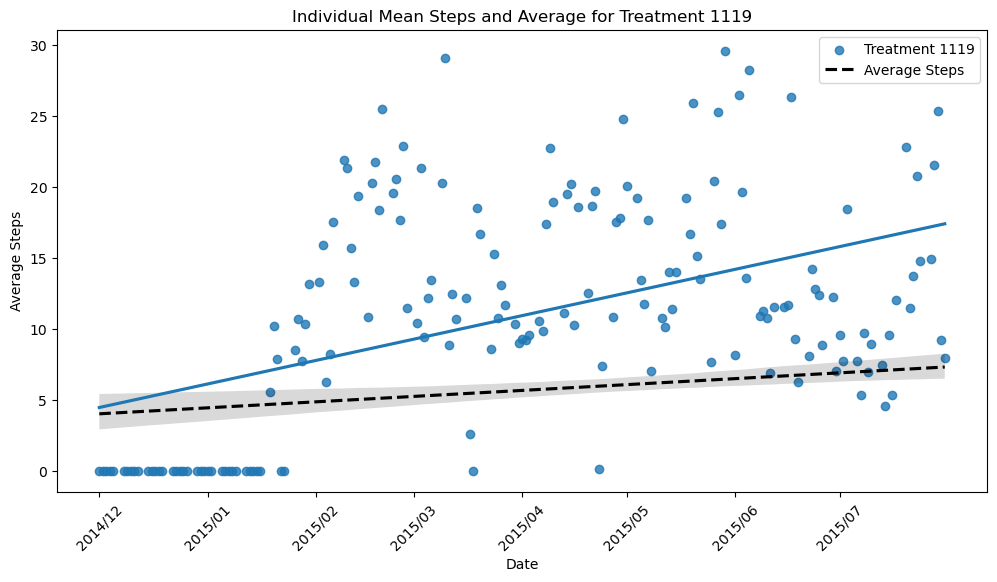

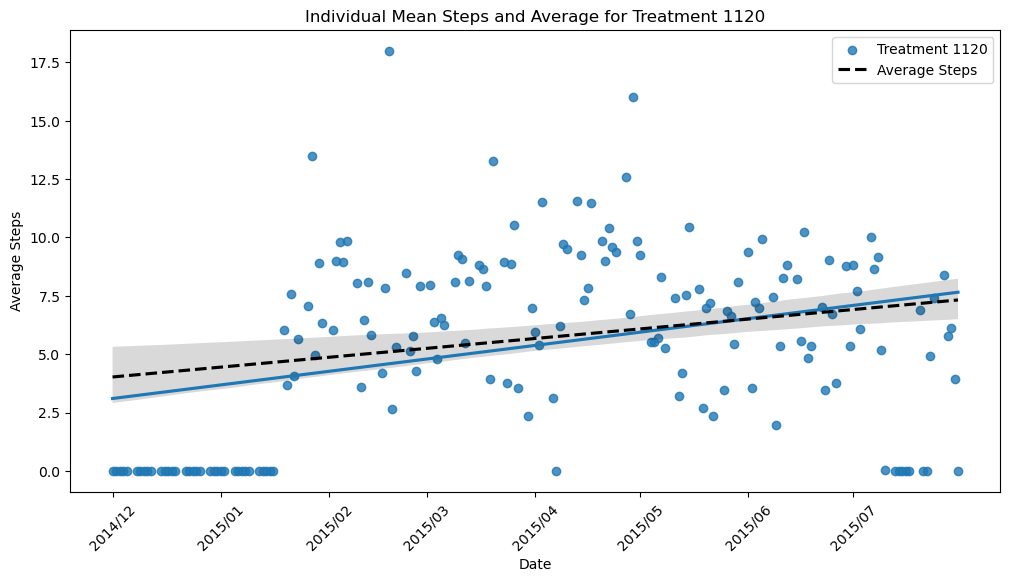

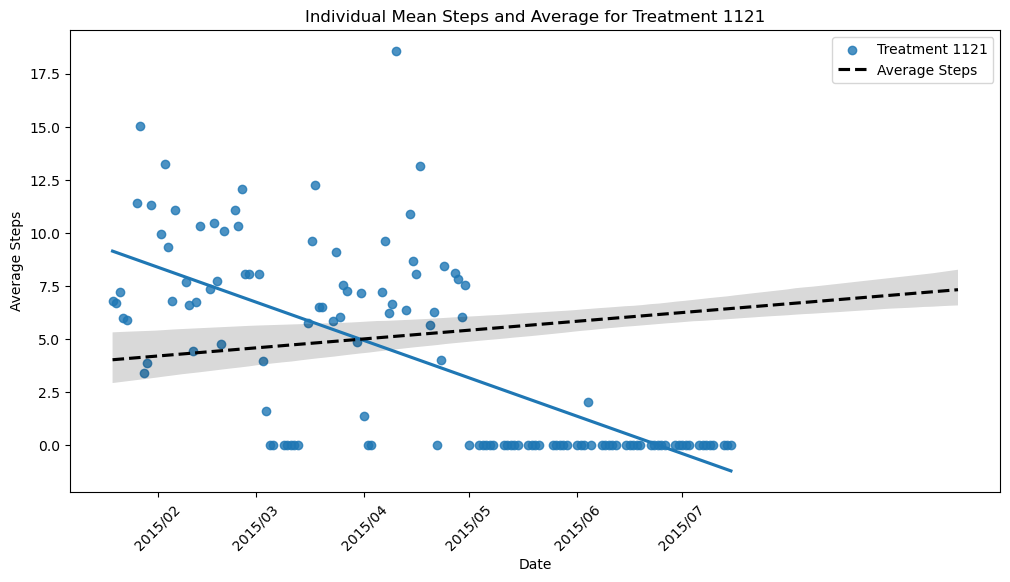

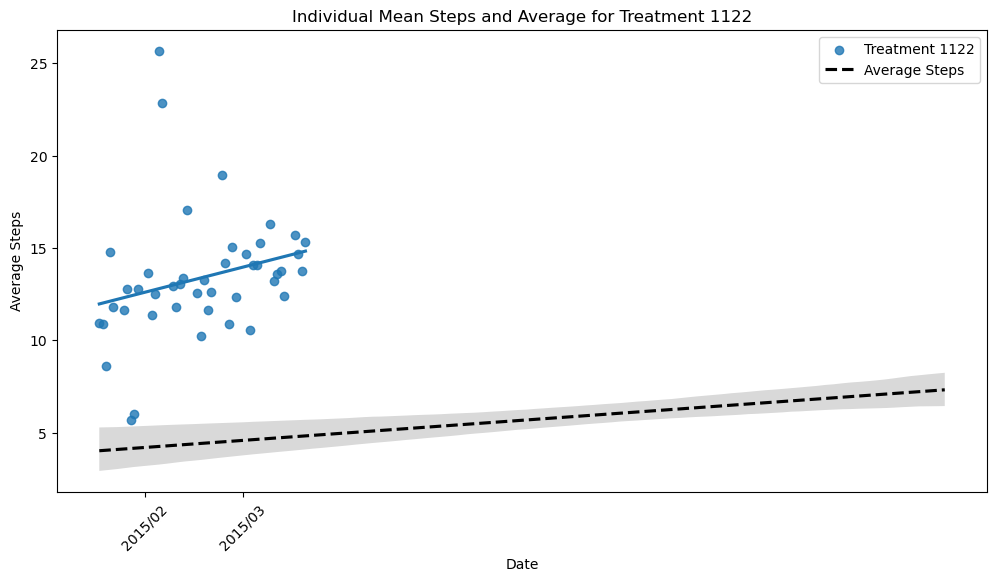

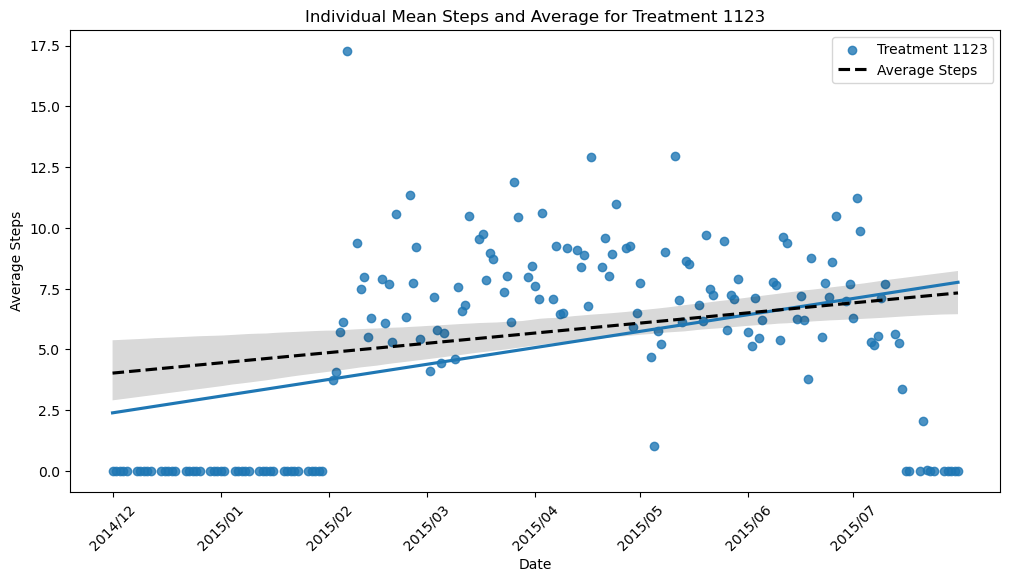

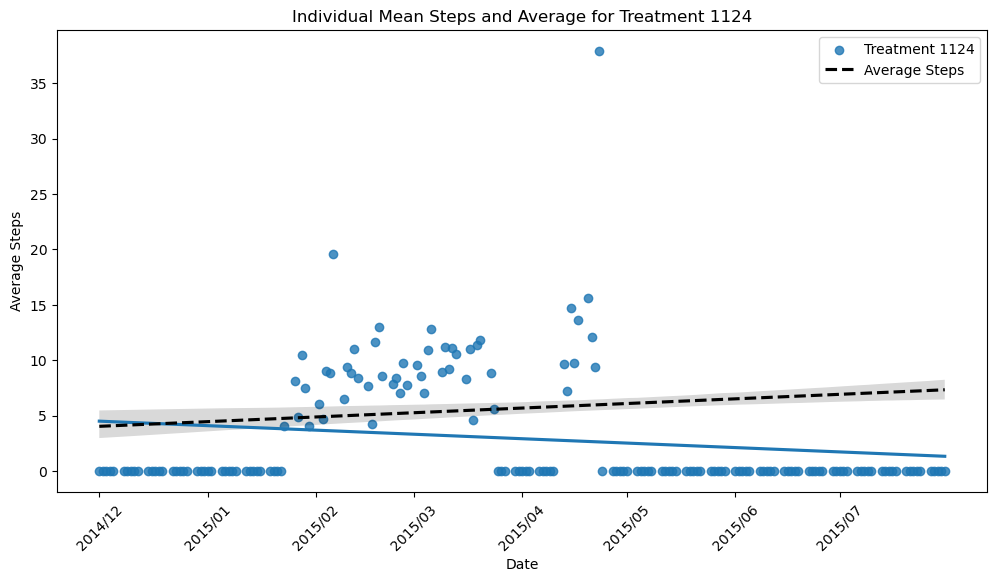

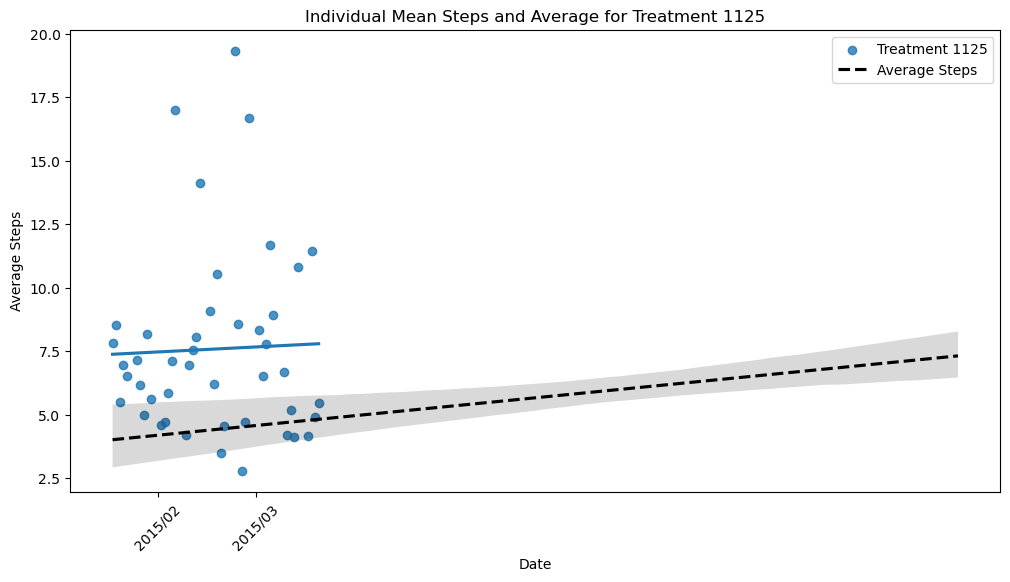

In [10]:
# -------- PLOT 3: Individual plots with average steps superposed --------

# Compute the average of all individuals' steps per day for Plot 2 (same as above)
average_steps = df.groupby([df['date'].dt.date])['steps'].mean().reset_index()

# Convert 'date' back to datetime format
average_steps['date'] = pd.to_datetime(average_steps['date'])

# Convert 'date' to numeric for regression (safe modification)
average_steps['date_numeric'] = (average_steps['date'] - average_steps['date'].min()).dt.days

# Loop through all treatment_ids for individual plots
for treatment in treatment_ids:
    plt.figure(figsize=(12, 6))
    
    # Filter data for the current treatment_id
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()  # Use .copy() here
    
    # Convert 'date' to numeric for regression (safe modification)
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days
    
    # Plot regression for this individual
    sns.regplot(data=subset, x='date_numeric', y='steps', scatter=True, ci=None, label=f'Treatment {treatment}')
    
    # Plot the average steps for all individuals (same as Plot 2)
    sns.regplot(data=average_steps, x='date_numeric', y='steps', scatter=False, color='black', label='Average Steps', line_kws={'color': 'black', 'linestyle': '--'})
    
    # Set the x-ticks to the first day of each month (same as Plot 2)
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')  # First day of each month
    month_numeric = (months - subset['date'].min()).days  # Convert the months to numeric
    
    # Apply the same x-tick formatting as in Plot 2 (YYYY/MM format)
    plt.xticks(month_numeric, months.strftime('%Y/%m'), rotation=45)  # Format x-ticks as YYYY/MM and rotate for better readability
    
    # Formatting
    plt.title(f"Individual Mean Steps and Average for Treatment {treatment}")
    plt.xlabel("Date")
    plt.ylabel("Average Steps")
    plt.legend()
    plt.show()


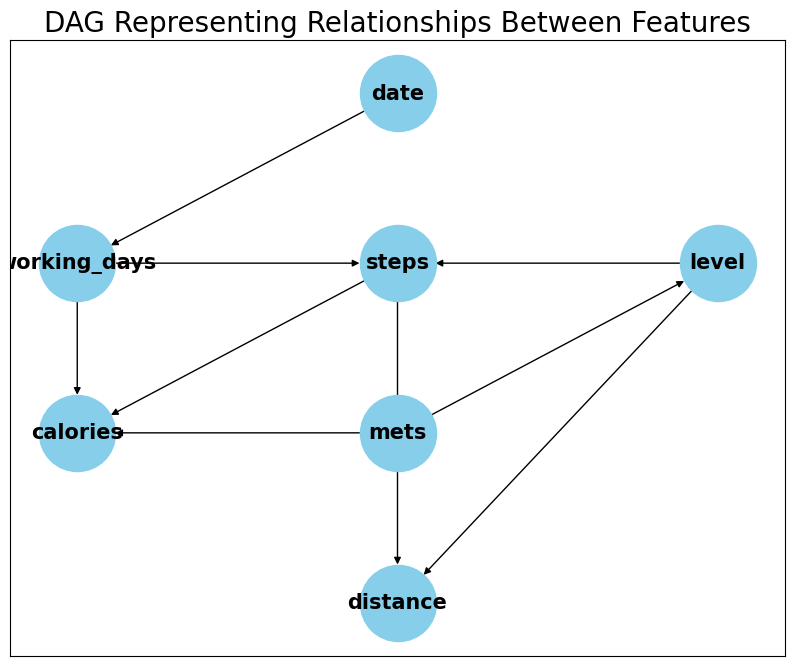

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph
dag = nx.DiGraph()

# Add nodes (features)
features = ['date', 'working_days', 'calories', 'mets', 'level', 'steps', 'distance']
dag.add_nodes_from(features)

# Define the relationships based on correlation analysis
edges = [
    ('date', 'working_days'),
    ('working_days', 'calories'),
    ('working_days', 'steps'),
    ('mets', 'calories'),
    ('steps', 'calories'),
    ('mets', 'level'),
    ('level', 'steps'),
    ('level', 'distance'),
    ('steps', 'distance')
]

dag.add_edges_from(edges)

# Define custom positions for some nodes
pos = {
    'date': (0, 1),            # Position en haut pour 'date'
    'working_days': (-1, 0),   # Position à gauche pour 'working_days'
    'calories': (-1, -1),        # 'calories' au centre
    'mets': (0, -1),            # 'mets' à droite de 'calories'
    'level': (1, 0),          # 'level' en dessous de 'calories'
    'steps': (0, 0),          # 'steps' en dessous de 'mets'
    'distance': (0, -2)        # 'distance' en bas de 'level'
}

# Visualize the DAG with custom positions
plt.figure(figsize=(10, 8))
nx.draw_networkx(dag, pos, with_labels=True, node_size=3000, node_color="skyblue", 
                 font_size=15, font_weight='bold', edge_color='black')
plt.title("DAG Representing Relationships Between Features", fontsize=20)
plt.show()


Correlation Matrix:
              treatment_id  fitbit_id  calories      mets     level     steps  \
treatment_id      1.000000   0.494536 -0.086128 -0.079460 -0.062669 -0.082287   
fitbit_id         0.494536   1.000000 -0.112657 -0.072801 -0.067629 -0.059734   
calories         -0.086128  -0.112657  1.000000  0.979686  0.932253  0.952129   
mets             -0.079460  -0.072801  0.979686  1.000000  0.956063  0.965284   
level            -0.062669  -0.067629  0.932253  0.956063  1.000000  0.906922   
steps            -0.082287  -0.059734  0.952129  0.965284  0.906922  1.000000   
distance         -0.074817  -0.059446  0.954111  0.964491  0.904313  0.998532   

              distance  
treatment_id -0.074817  
fitbit_id    -0.059446  
calories      0.954111  
mets          0.964491  
level         0.904313  
steps         0.998532  
distance      1.000000  


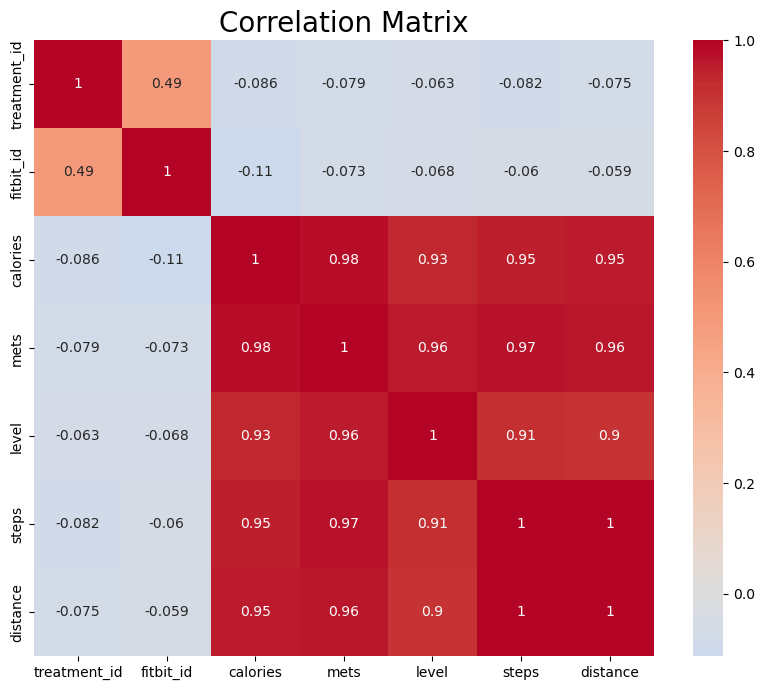

In [12]:
# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# Keep only numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr = df_numeric.corr()

# Print correlation matrix as a table
print("Correlation Matrix:")
print(corr)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix", fontsize=20)
plt.show()